In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE  # To handle class imbalance

# Loading the Dataset
df = pd.read_csv("cardio.csv", delimiter=";")

# Basic Dataset Information
print("Dataset Info:")
print(df.info())
print("\nDataset Description:")
print(df.describe())
print("\nColumn Names:")
print(df.columns)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB
None

Dataset Description:
                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   4997

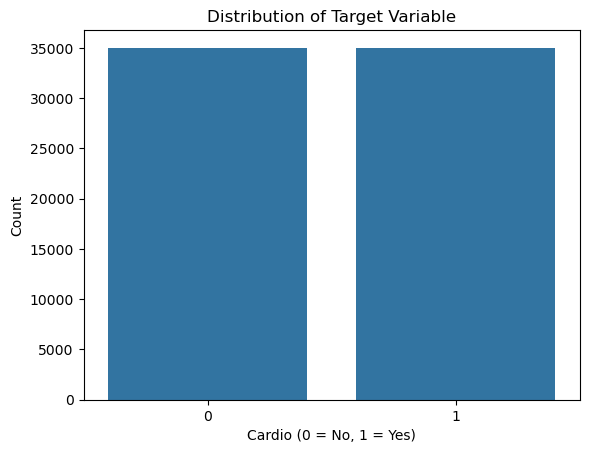

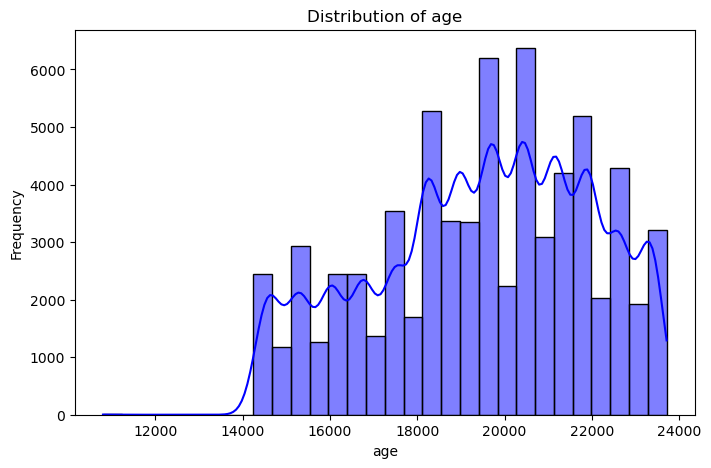

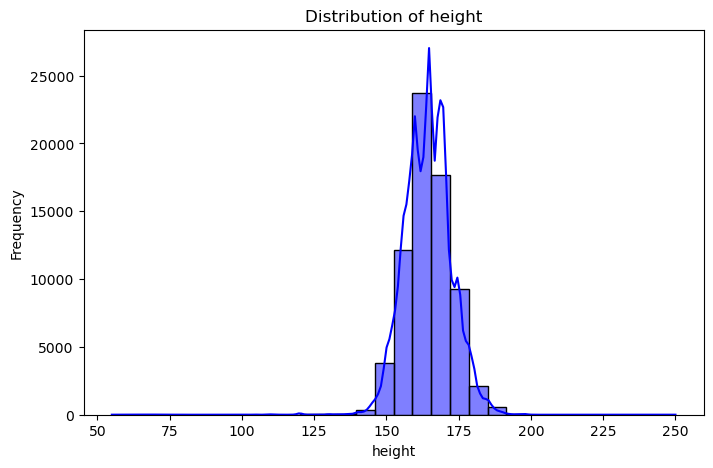

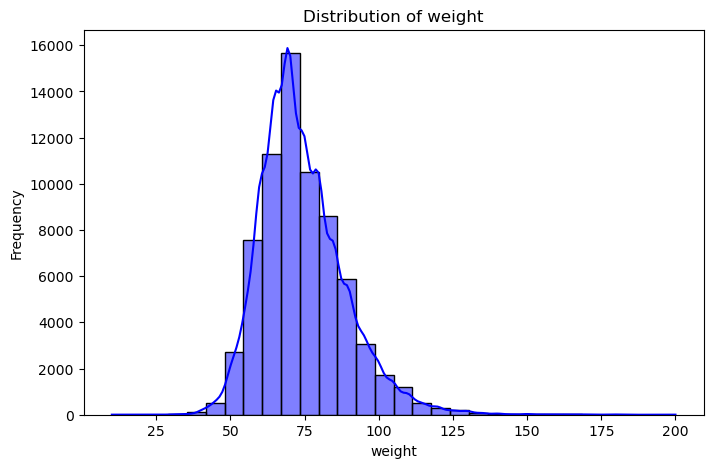

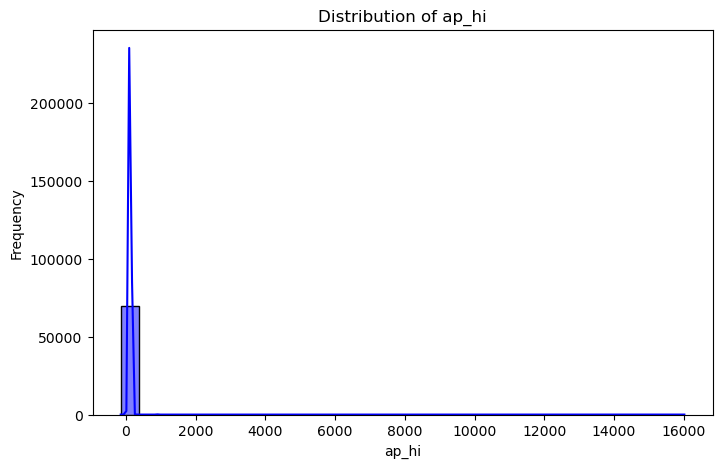

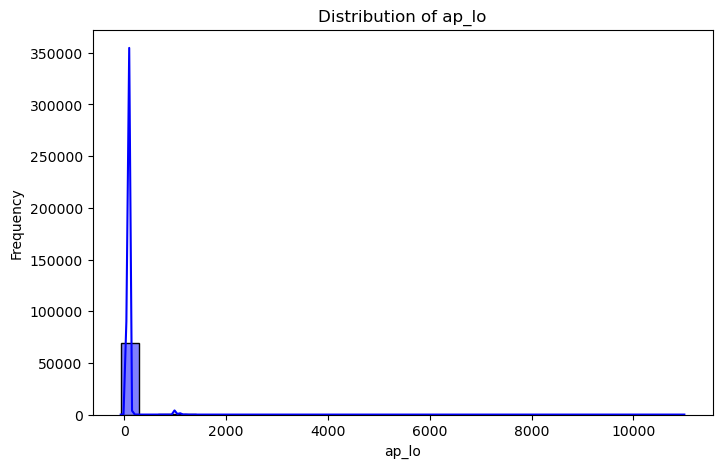

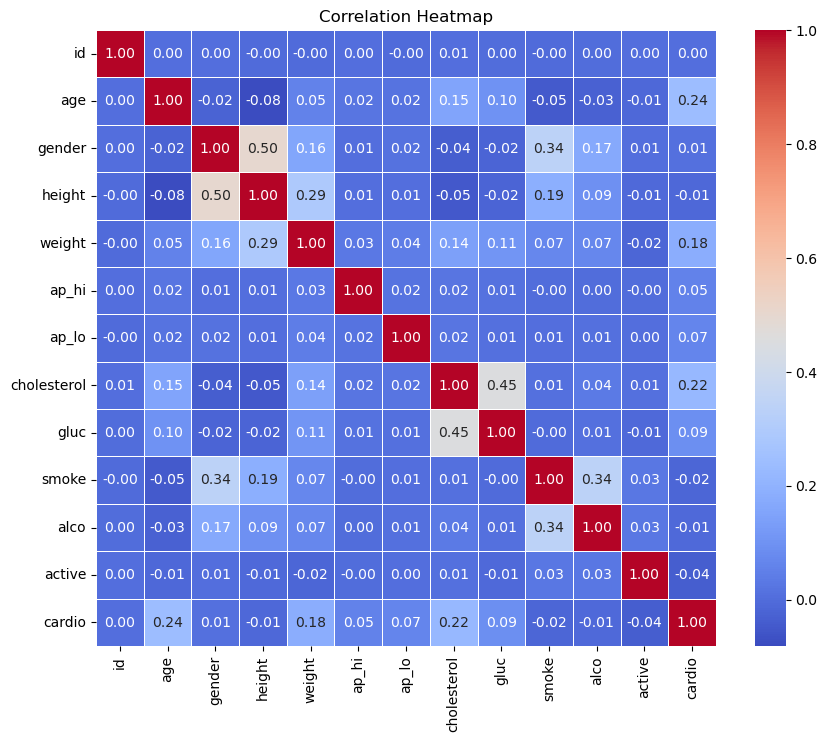

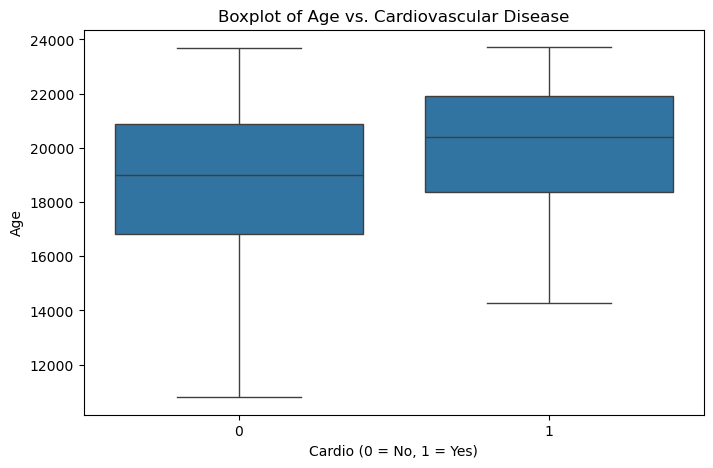

In [2]:
# Visualizations

# 1. Visualize Target Variable Distribution
sns.countplot(x='cardio', data=df)
plt.title("Distribution of Target Variable")
plt.xlabel("Cardio (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# 2. Distribution of Continuous Variables
continuous_features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
for feature in continuous_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[feature], kde=True, bins=30, color='blue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# 4. Boxplot for Age vs. Cardiovascular Disease
plt.figure(figsize=(8, 5))
sns.boxplot(x='cardio', y='age', data=df)
plt.title("Boxplot of Age vs. Cardiovascular Disease")
plt.xlabel("Cardio (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()

In [3]:
# Preprocessing

# Drop Irrelevant Column
df = df.drop(columns=['id'])

# Map Gender to Binary (1 = male, 0 = female)
df['gender'] = df['gender'].map({1: 0, 2: 1})

# Handle Outliers for Blood Pressure
df = df[(df['ap_hi'] > 50) & (df['ap_hi'] < 250)]  
df = df[(df['ap_lo'] > 30) & (df['ap_lo'] < 200)]  

# Feature Engineering
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2 
df['bp_ratio'] = df['ap_hi'] / df['ap_lo']          

# Normalize Continuous Variables
scaler = StandardScaler()
columns_to_scale = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi', 'bp_ratio']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Split Data into Features and Target
X = df.drop('cardio', axis=1) 
y = df['cardio']             

# Train-test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Logistic Regression Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression Performance:
Accuracy: 0.733769538349691
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.75      0.74      6795
           1       0.75      0.72      0.73      6960

    accuracy                           0.73     13755
   macro avg       0.73      0.73      0.73     13755
weighted avg       0.73      0.73      0.73     13755



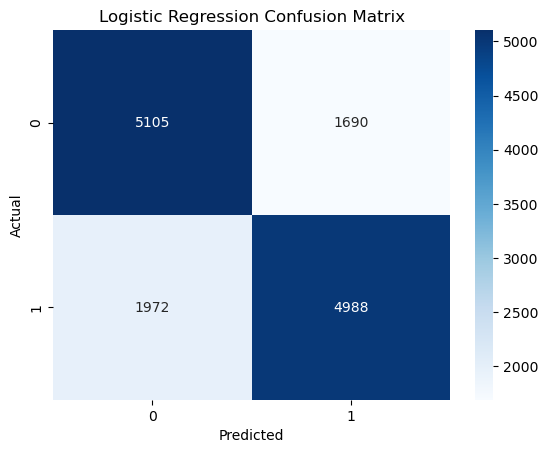

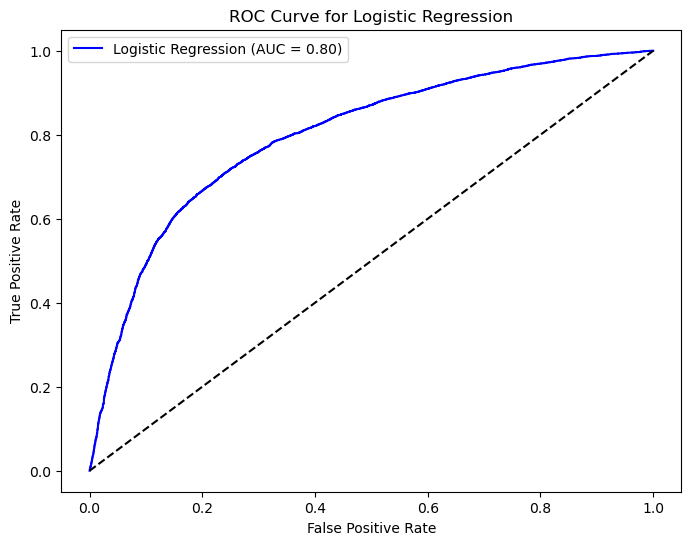

In [4]:
# Logistic Regression

# Polynomial Features for Interaction Terms
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_train_resampled)
X_test_poly = poly.transform(X_test)

# Hyperparameter Tuning for Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],       
    'solver': ['liblinear']       
}

grid_search_lr = GridSearchCV(LogisticRegression(class_weight='balanced'), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train_poly, y_train_resampled)

# Best Parameters
print("Logistic Regression Best Parameters:", grid_search_lr.best_params_)

# Train Logistic Regression with Best Parameters
log_reg = grid_search_lr.best_estimator_
log_reg.fit(X_train_poly, y_train_resampled)

# Predictions and Evaluation for Logistic Regression
y_pred_lr = log_reg.predict(X_test_poly)
y_prob_lr = log_reg.predict_proba(X_test_poly)[:, 1]

print("\nLogistic Regression Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

# Logistic Regression Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Logistic Regression AUC-ROC Curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_prob_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--')  
plt.title("ROC Curve for Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

Random Forest Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

Random Forest Performance:
Accuracy: 0.7333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74      6795
           1       0.76      0.70      0.73      6960

    accuracy                           0.73     13755
   macro avg       0.73      0.73      0.73     13755
weighted avg       0.74      0.73      0.73     13755



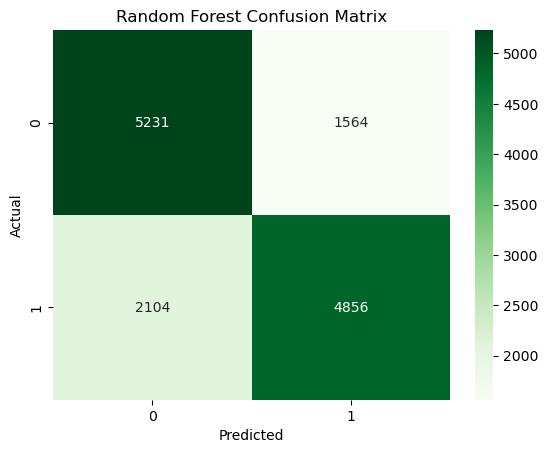

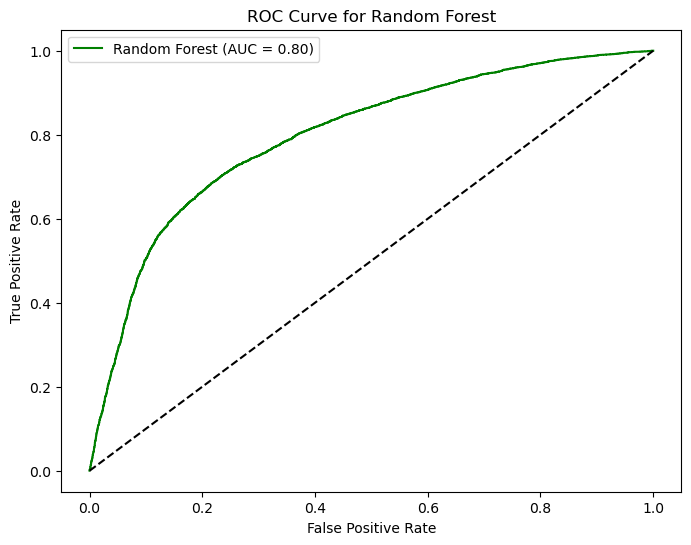

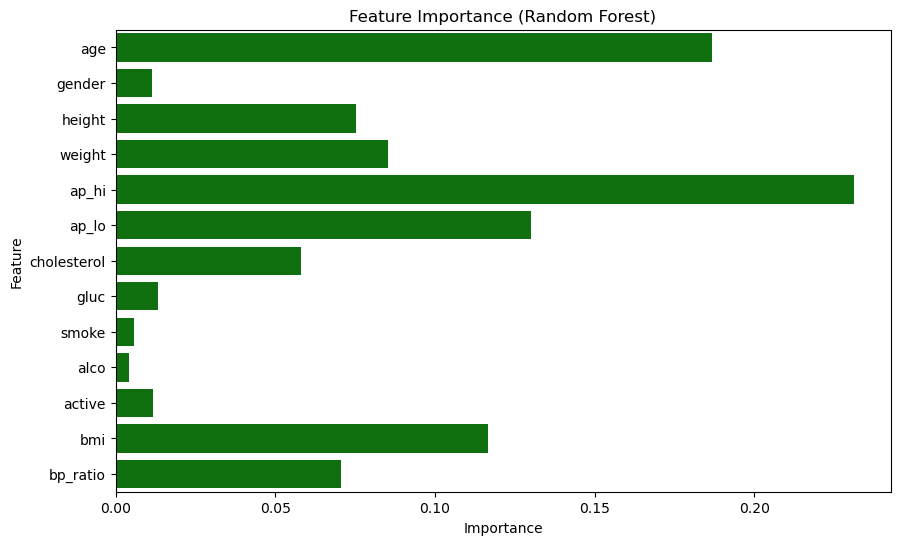

In [5]:
# Random Forest

# Hyperparameter Tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Best Parameters
print("Random Forest Best Parameters:", grid_search_rf.best_params_)

# Train Random Forest with Best Parameters
rf = grid_search_rf.best_estimator_
rf.fit(X_train_resampled, y_train_resampled)

# Predictions and Evaluation for Random Forest
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\nRandom Forest Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Random Forest AUC-ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--')  
plt.title("ROC Curve for Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# Random Forest Feature Importance
importances = rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names, color='green')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()